# Part 3: End-to-End Example training object detection model using NVIDIA Pytorch Container from NGC
## Training and Inference via NGC Container
 ----

Note this Object Detection demo is based on https://github.com/pytorch/vision/tree/v0.11.3

This notebook walks you each step to train a model using containers from the NGC Catalog. We chose the GPU optimized Pytorch container as an example. The basics of working with docker containers apply to all NGC containers.

We will show you how to:

* Execute training a object detection on satellite imagery using TensorFlow and Jupyter Notebook
* Run inference on a trained object detection model using the SAHI library

Let's get started!

---

In [4]:
%%capture
!pip install cython pycocotools matplotlib terminaltables


# TLDR; run training job on 8 GPUS
The below cell will run a multi-gpu training job. This job will train an object detection model (faster-rcnn) on a dataset of satellite imagery images that contain 61 classes of objects
* Change `nproc_per_node` argument to specify the number of GPUs available on your server

In [ ]:
!torchrun --nproc_per_node=8 detection/train.py\
    --dataset coco --data-path=/run/determined/workdir/shared_fs/data/xview_dataset/ --model fasterrcnn_resnet50_fpn --epochs 26\
    --lr-steps 16 22 --aspect-ratio-group-factor 3

### 1. Object Detection on Satellite Imagery with Pytorch (Single GPU)
Follow and Run the code to train a Faster RCNN FPN (Resnet50 backbone) that classifies images of clothing. 

In [2]:
import sys
sys.path.insert(0,'detection')

In [3]:
# Import python dependencies
import datetime
import os
import time

import torch
import torch.utils.data
import torchvision
import torchvision.models.detection
import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco, get_coco_kp

from group_by_aspect_ratio import GroupedBatchSampler, create_aspect_ratio_groups
from engine import train_one_epoch, evaluate

import presets
import utils
from coco_utils import get_coco, get_coco_kp
from train import get_dataset, get_transform
from group_by_aspect_ratio import GroupedBatchSampler, create_aspect_ratio_groups
from engine import train_one_epoch, evaluate
from models import build_frcnn_model
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from collections import OrderedDict
from tqdm import tqdm
from vis_utils import load_determined_state_dict, visualize_pred, visualize_gt, predict
import numpy as np

import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
output_dir='output'
data_path='/run/determined/workdir/shared_fs/data/xview_dataset/'
dataset_name='coco'
model_name='fasterrcnn_resnet50_fpn'
device='cpu'
batch_size=8
epochs=26
workers=4
lr=0.02
momentum=0.9
weight_decay=1e-4
lr_scheduler='multisteplr'
lr_step_size=8
lr_steps=[16, 22]
lr_gamma=0.1
print_freq=20
resume=False
start_epoch=0
aspect_ratio_group_factor=3
rpn_score_thresh=None
trainable_backbone_layers=None
data_augmentation='hflip'
pretrained=True
test_only=False
sync_bn=False

In [6]:
# Import the dataset.
# Data loading code
print("Loading data")

dataset, num_classes = get_dataset(dataset_name, "train", get_transform(True, data_augmentation),
                                   data_path)
dataset_test, _ = get_dataset(dataset_name, "val", get_transform(False, data_augmentation), data_path)
print(dataset.num_classes)
print("Creating data loaders")
train_sampler = torch.utils.data.RandomSampler(dataset)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)
group_ids = create_aspect_ratio_groups(dataset, k=aspect_ratio_group_factor)
train_batch_sampler = GroupedBatchSampler(train_sampler, group_ids, batch_size)
train_batch_sampler = torch.utils.data.BatchSampler(
            train_sampler, batch_size, drop_last=True)

data_loader = torch.utils.data.DataLoader(
    dataset, batch_sampler=train_batch_sampler, num_workers=workers,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1,
    sampler=test_sampler, num_workers=0,
    collate_fn=utils.collate_fn)


Loading data
loading annotations into memory...
Done (t=2.93s)
creating index...
index created!
self.catIdtoCls:  {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53, 53: 54, 54: 55, 55: 56, 56: 57, 57: 58, 58: 59, 59: 60}
self.num_classes:  61
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 

In [7]:
# Getting three examples from the test dataset
inds_that_have_boxes = []
test_images = list(data_loader_test)
for ind,(im,targets) in tqdm(enumerate(test_images),total=len(list(data_loader_test))):
    # print(ind,targets)
    if targets[0]['boxes'].shape[0]>0:
        # print(targets[0]['boxes'].shape[0])
        # print(ind,targets)
        inds_that_have_boxes.append(ind)

images_t_list=[]
targets_t_list=[]
for ind in tqdm(range(3)):
    im,targets = test_images[ind]
    images_t_list.append(im[0])
    targets_t_list.append(targets[0])

100%|██████████| 3/3 [00:00<00:00, 39199.10it/s]


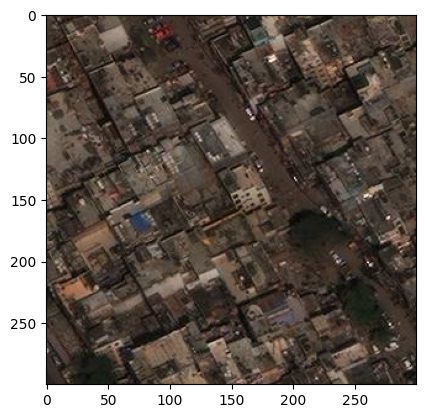

In [8]:
# Let's have a look at one of the images. The following code visualizes the images using the matplotlib library.
im = Image.fromarray((255.*images_t_list[0].cpu().permute((1,2,0)).numpy()).astype(np.uint8))
plt.imshow(im)
plt.show()

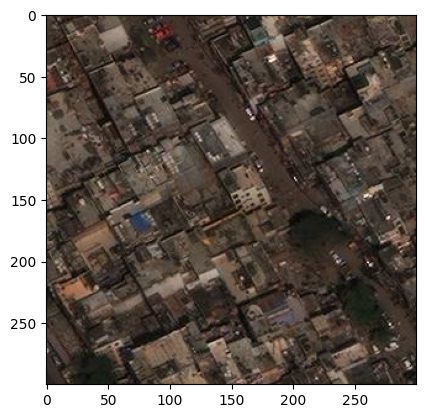

Num GT Boxes:  66


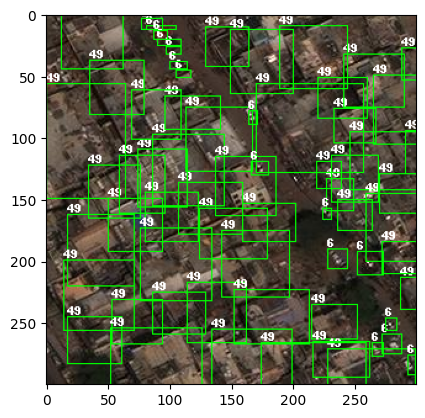

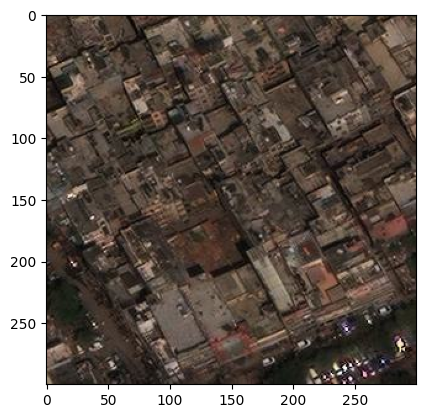

Num GT Boxes:  72


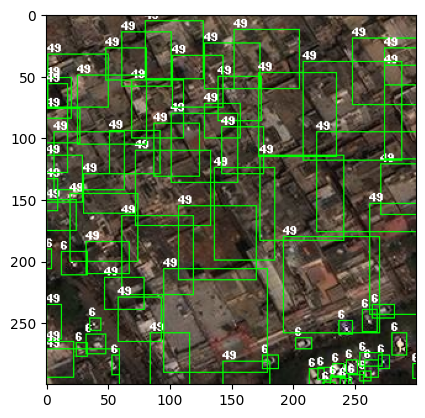

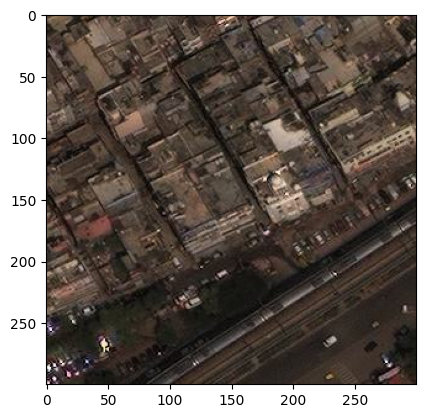

Num GT Boxes:  67


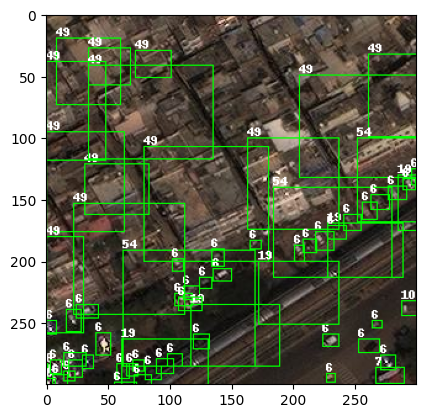

In [9]:
# Let's look again at the first three images, but this time with the class names.

for i,t in zip(images_t_list,targets_t_list):
    im = Image.fromarray((255.*i.cpu().permute((1,2,0)).numpy()).astype(np.uint8))
    plt.imshow(im)
    plt.show()
    im = visualize_gt(i,t)
    plt.imshow(im)
    plt.show()

In [10]:
# Let's build the model:
print("Creating model")
print("Number of classes: ",dataset.num_classes)
model = build_frcnn_model(num_classes=dataset.num_classes)
_=model.to('cpu')



Creating model
Number of classes:  61
Loading pretrained model...


In [ ]:
# Compile the model:
# Define loss function, optimizer, and metrics.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=lr, momentum=momentum, weight_decay=weight_decay)

lr_scheduler = lr_scheduler.lower()
if lr_scheduler == 'multisteplr':
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                        milestones=lr_steps, 
                                                        gamma=lr_gamma)
elif lr_scheduler == 'cosineannealinglr':
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
else:
    raise RuntimeError("Invalid lr scheduler '{}'. Only MultiStepLR and CosineAnnealingLR "
                       "are supported.".format(args.lr_scheduler))


In [ ]:
# Train the model:
# Let's train 1 epoch. After every epoch, training time, loss, and accuracy will be displayed.
print("Start training")
start_time = time.time()
for epoch in range(start_epoch, epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq)
    lr_scheduler.step()
    if output_dir:
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'args': args,
            'epoch': epoch
        }
        utils.save_on_master(
            checkpoint,
            os.path.join(output_dir, 'model_{}.pth'.format(epoch)))
        utils.save_on_master(
            checkpoint,
            os.path.join(output_dir, 'checkpoint.pth'))

    # evaluate after every epoch
    evaluate(model, data_loader_test, device=device)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

In [19]:
def build_frcnn_model2(num_classes):
    print("Loading pretrained model...")
    # load an detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.min_size=800
    model.max_size=1333
    # RPN parameters
    model.rpn_pre_nms_top_n_train=2000
    model.rpn_pre_nms_top_n_test=1000
    model.rpn_post_nms_top_n_train=2000
    model.rpn_post_nms_top_n_test=1000
    model.rpn_nms_thresh=1.0
    model.rpn_fg_iou_thresh=0.7
    model.rpn_bg_iou_thresh=0.3
    model.rpn_batch_size_per_image=256
    model.rpn_positive_fraction=0.5
    model.rpn_score_thresh=0.05
    # Box parameters
    model.box_score_thresh=0.0
    model.box_nms_thresh=1.0
    model.box_detections_per_img=500
    model.box_fg_iou_thresh=1.0
    model.box_bg_iou_thresh=1.0
    model.box_batch_size_per_image=512
    model.box_positive_fraction=0.25
    return model

In [28]:
# Let's see how the model performs on the test data:
model = build_frcnn_model2(num_classes=61)
ckpt = torch.load('/run/determined/workdir/e2e_blogposts/ngc_blog/model_8.pth',map_location='cpu')
model.load_state_dict(ckpt['model'])
_=model.eval()


Loading pretrained model...


Num GT Boxes:  66
Num Pred Boxes:  100


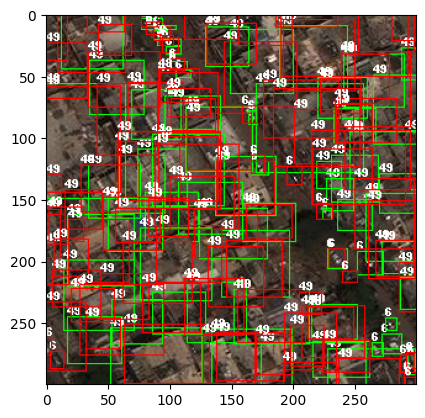

Num GT Boxes:  72
Num Pred Boxes:  100


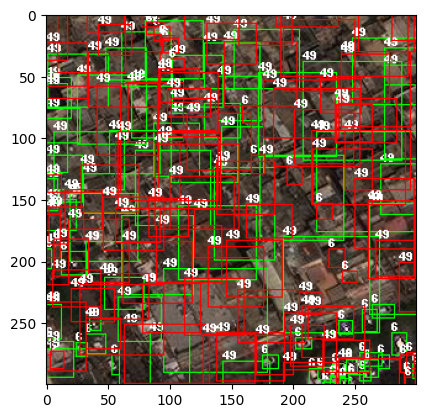

Num GT Boxes:  67
Num Pred Boxes:  100


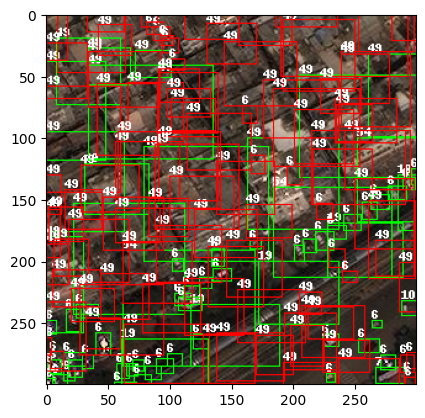

In [29]:
_=predict(model,images_t_list,targets_t_list)